In [2]:
import time
import random
import keyboard
import pygame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym

In [13]:
env = gym.make("FrozenLake-v1",
               desc=None,
               render_mode='human',
               map_name='4x4',
               is_slippery=False)

s, info = env.reset()

print(env.action_space.n)
print(env.observation_space.n)
# display(env.unwrapped.P)

obs, _ = env.reset()
print(obs)

try:
    for i in range(1000):
        if keyboard.is_pressed("q"):
            break
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            obs, info = env.reset()
finally:
    env.close()

4
16
0


## Deterministic policy

In [34]:
env = gym.make('FrozenLake-v1',
               desc=None,
               map_name='4x4',
               is_slippery=False)

policy = {0: 1, 1: 2, 2: 1, 3: 0, 
          4: 1, 6: 1, 8: 2, 9: 1, 
          10: 1, 13: 2, 14: 2}

scores = []
stochastic = True
success = 0
num_episode = 1000000

for i in range(num_episode):
    # if i == 990:
    #     env = gym.make('FrozenLake-v1',
    #                    desc=None,
    #                    render_mode='human',
    #                    map_name='4x4',
    #                    is_slippery=False)
        
    if keyboard.is_pressed('q'):
        print("Exiting the environment.....")
        break

    terminated, truncated = False, False
    s, info = env.reset()
    score = 0

    while not terminated:
        if stochastic:
            action = env.action_space.sample()
        else:
            action = policy[s]

        s_, reward, terminated, truncated, info = env.step(action)
        score += reward
        s = s_

        if reward:
            success += 1

    scores.append(score)

env.close()

print(f'success : {(success/num_episode)*100}%')

success : 1.3882%


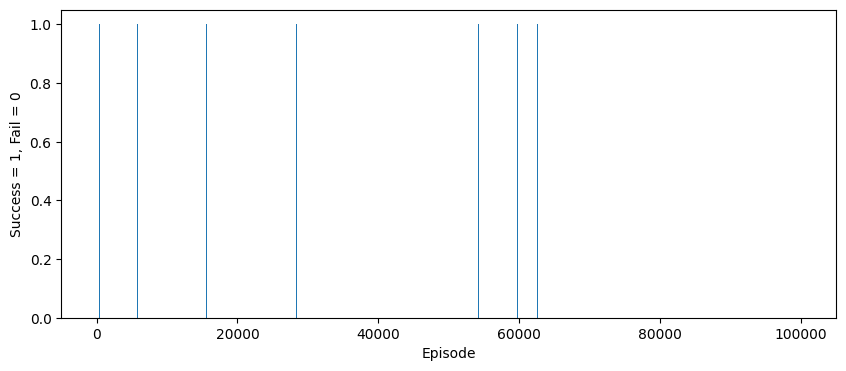

In [32]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(scores)), scores)
plt.xlabel("Episode")
plt.ylabel('Success = 1, Fail = 0')
plt.show()

## Policy evaluation

In [38]:
env = gym.make('FrozenLake-v1',
               desc=None,
               map_name='4x4',
               is_slippery=False)

num_states = env.observation_space.n  # 16
num_actions = env.action_space.n      # 4
transitions = env.unwrapped.P

print('num_states :', num_states)
print('num_actions :', num_actions)
print('='*50)
display('transitions :', transitions)

num_states : 16
num_actions : 4


'transitions :'

{0: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 4, 0.0, False)],
  2: [(1.0, 1, 0.0, False)],
  3: [(1.0, 0, 0.0, False)]},
 1: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 5, 0.0, True)],
  2: [(1.0, 2, 0.0, False)],
  3: [(1.0, 1, 0.0, False)]},
 2: {0: [(1.0, 1, 0.0, False)],
  1: [(1.0, 6, 0.0, False)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 7, 0.0, True)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 4: {0: [(1.0, 4, 0.0, False)],
  1: [(1.0, 8, 0.0, False)],
  2: [(1.0, 5, 0.0, True)],
  3: [(1.0, 0, 0.0, False)]},
 5: {0: [(1.0, 5, 0, True)],
  1: [(1.0, 5, 0, True)],
  2: [(1.0, 5, 0, True)],
  3: [(1.0, 5, 0, True)]},
 6: {0: [(1.0, 5, 0.0, True)],
  1: [(1.0, 10, 0.0, False)],
  2: [(1.0, 7, 0.0, True)],
  3: [(1.0, 2, 0.0, False)]},
 7: {0: [(1.0, 7, 0, True)],
  1: [(1.0, 7, 0, True)],
  2: [(1.0, 7, 0, True)],
  3: [(1.0, 7, 0, True)]},
 8: {0: [(1.0, 8, 0.0, False)],
  1: [(1.0, 12, 0.0, True)],
  2: [(

In [64]:
V = np.zeros(num_states)
pi = np.ones([num_states, num_actions]) * 0.25  # stochastic policy

print('V =', V)
print('pi = \n', pi)

V = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pi = 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [65]:
gamma = 0.95
theta = 1e-3
count = 0

while True:
    delta = 0
    count += 1

    for s in range(num_states):
        old_value = V[s]
        new_value = 0

        for a, prob_action in enumerate(pi[s]):
            for prob_environ, s_, reward, terminated in transitions[s][a]:
                new_value += prob_action*prob_environ*(reward + gamma*V[s_])
        V[s] = new_value

        delta = max(delta, np.abs(old_value - V[s]))
        
    if delta <= theta:
        break

print(count)
print(delta)
print(V)

10
0.0009385641113857784
[0.00475825 0.00513419 0.01288317 0.00548208 0.0085746  0.
 0.03198519 0.         0.024155   0.07018057 0.12215442 0.
 0.         0.15007626 0.41254484 0.        ]


,0,1,2,3
0,0.0048,0.0051,0.0129,0.0055
1,0.0086,0.0000,0.0320,0.0000
2,0.0242,0.0702,0.1222,0.0000
3,0.0000,0.1501,0.4125,0.0000


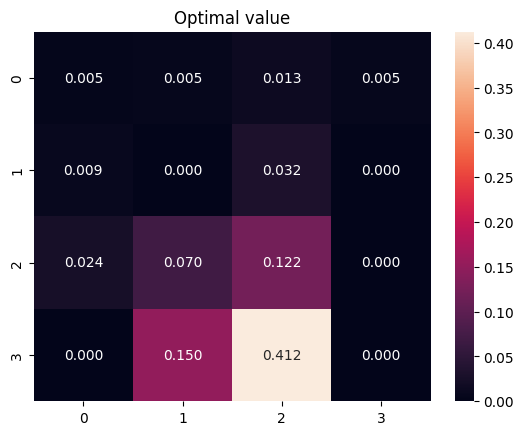

In [73]:
df = pd.DataFrame(V.reshape(4, 4).round(4))
display(df)

sns.heatmap(df, annot=True, fmt='.3f')
plt.title('Optimal value')
plt.show()

## 정책 반복 (Policy Iteration)

In [105]:
env = gym.make('FrozenLake-v1',
               desc=None,
               map_name='4x4',
               is_slippery=False)

num_states = env.observation_space.n
num_actions = env.action_space.n
transitions = env.unwrapped.P

print('num_states =', num_states)
print('num_actions =', num_actions)

num_states = 16
num_actions = 4


In [106]:
## parameters init

V = np.zeros(num_states)
pi = np.ones([num_states, num_actions])*0.25
print("V =", V)
print("pi =\n", pi)

V = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pi =
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [ ]:
V = np.zeros(num_states)
pi = np.ones([num_states, num_actions])*0.25

gamma = 0.95
theta = 1e-5 # 0.00001
policy_converge = False # Policy
count = 0

while not policy_converge:
    count += 1

    while True:
        delta = 0
        for s in range(num_states):
            old_value = V[s]
            new_value = 0

            for a, prob_action in enumerate(pi[s]):
                for prob_environ, s_, reward, terminated_, in transitions[s][a]:
                    new_value += prob_action*prob_environ*(reward + gamma*V[s_])
            V[s] = new_value

            delta = max(delta, np.abs(old_value - V[s]))

        if delta < theta:
            break
    
    ## policy update
    old_pi = np.copy(pi)

    for s in range(num_states):

        new_action_values = np.zeros(num_actions) # [0, 0, 0, 0]
        for a in range(num_actions):
            for prob_environ, s_, reward, _ in transitions[s][a]:
                new_action_values[a] += prob_environ*(reward+gamma*V[s_])

        new_action = np.argmax(new_action_values)

        pi[s] = np.eye(num_actions)[new_action]

    print(f'iteration = {count}')

    if (old_pi == pi).all():
        print("converge = True")
        policy_converge = True

iteration = 1
iteration = 2
converge = True


,0,1,2,3
0,0.773781,0.814506,0.857375,0.814506
1,0.814506,0.000000,0.902500,0.000000
2,0.857375,0.902500,0.950000,0.000000
3,0.000000,0.950000,1.000000,0.000000


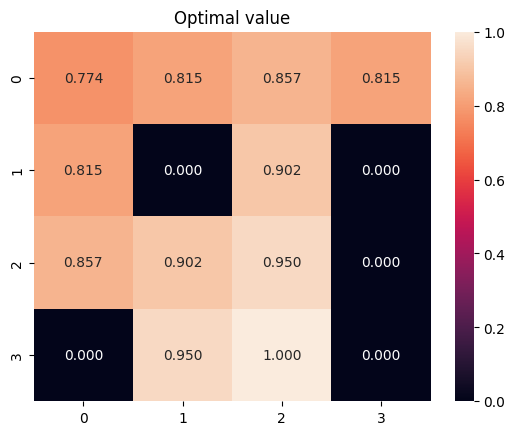

pi = 
 [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Optimal Action = 
 [[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [119]:
df = pd.DataFrame(V.reshape(4, 4))
display(df)

sns.heatmap(df, annot=True, fmt='.3f')
plt.title('Optimal value')
plt.show()

print("pi = \n", pi)
print("Optimal Action = \n", np.argmax(pi, axis=1).reshape(4, 4))

## 가치 반복 (Value Iteration)

In [120]:
env = gym.make('FrozenLake-v1',
               desc=None,
               map_name='4x4',
               is_slippery=False)

num_states = env.observation_space.n
num_actions = env.action_space.n
transitions = env.unwrapped.P

In [123]:
V = np.zeros(num_states)

gamma = 0.95
theta = 1e-3

while True:
    delta = 0

    for s in range(num_states):
        old_value = V[s]
        new_action_values = np.zeros(num_actions) # [0, 0, 0, 0]

        for a in range(num_actions):
            for prob_environ, s_, reward, _  in transitions[s][a]:
                new_action_values[a] += prob_environ*(reward + gamma*V[s_])

        v_max = max(new_action_values)
        V[s] = v_max
        delta = max(delta, np.abs(old_value - v_max))

    if delta < theta:
        break

pi = np.ones([num_states, num_actions])

for s in range(num_states):
    action_values = np.zeros(num_actions)

    for a in range(num_actions):
        for prob_environ, s_, reward, _ in transitions[s][a]:
            action_values[a] += prob_environ * (reward + gamma*V[s_])
    
    new_action = np.argmax(action_values)
    pi[s] = np.eye(num_actions)[new_action]

## value
df = pd.DataFrame(V.reshape(4, 4))
print("Optimal Value = \n", V)

## Policy
print("Optimal Policy = \n", pi)
print("Optimal Action = \n", np.argmax(pi, axis = 1).reshape(4, 4))

Optimal Value = 
 [0.77378094 0.81450625 0.857375   0.81450625 0.81450625 0.
 0.9025     0.         0.857375   0.9025     0.95       0.
 0.         0.95       1.         0.        ]
Optimal Policy = 
 [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Optimal Action = 
 [[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


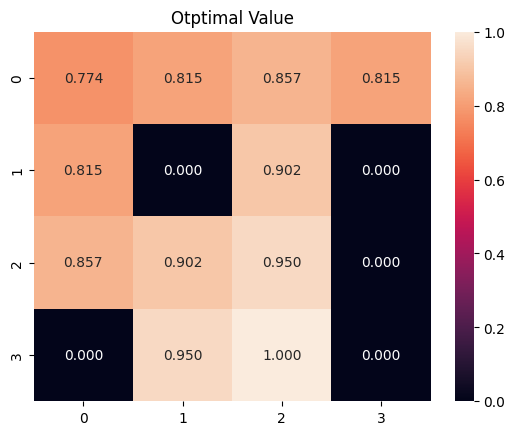

In [124]:
## heatmap
sns.heatmap(df, annot=True, fmt = ".3f")
plt.title("Otptimal Value")
plt.show()

# Monte Carlo method: blackjack first visit

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

In [357]:
## paramters
stick_threshold = 17
win_cnt = 0
lose_cnt = 0
draw_cnt = 0

num_episodes = 100_000

GAMMA = 1

In [358]:
env = gym.make('Blackjack-v1', sab=True)

env.action_space.n  # hit, stick

# 초기 카드값 합이 shreshold 이상이면 0 반환, 그 이외는 1 반환
def pi(state):
    return 0 if state[0] >= stick_threshold else 1

In [359]:
V = defaultdict(float)
Returns = defaultdict(list)

print(V)
print(Returns)

defaultdict(<class 'float'>, {})
defaultdict(<class 'list'>, {})


In [350]:
# test

s, _ = env.reset()
print('state =', s)
action = pi(s)
print('action =', action)
s_, r, terminated, truncated, _ = env.step(action)
print('next state =', s_)
print('reward =', r)
print('terminated =', terminated)

state = (21, 5, 1)
action = 0
next state = (21, 5, 1)
reward = 1.0
terminated = True


In [363]:
for i in range(num_episodes):

    episode = []
    s, _ = env.reset()

    while True:
        a = pi(s) # hit or stay
        s_, r, terminated, truncated, _ = env.step(a)

        episode.append((s, a, r))

        if terminated or truncated:
            if r == 1:
                win_cnt += 1
            elif r == -1:
                lose_cnt += 1
            else:
                draw_cnt += 1
            break
        s = s_

    G = 0

    visited_states = []

    for s, a, r in episode[::-1]:
        G = GAMMA*G + r

        if s not in visited_states:
            Returns[s].append(G)
            V[s] = np.mean(Returns[s])
            visited_states.append(s)

    if i % 5000 == 0:
        print(f"episode = {i}/{num_episodes} completed")

print("Policy : stick threshold =  {}".format(stick_threshold))
print("win ratio = {:2f}%".format(100*win_cnt/num_episodes))
print("lose ratio = {:2f}%".format(100*lose_cnt/num_episodes))
print("draw ratio = {:2f}%".format(100*draw_cnt/num_episodes))

episode = 0/100000 completed
episode = 5000/100000 completed
episode = 10000/100000 completed
episode = 15000/100000 completed
episode = 20000/100000 completed
episode = 25000/100000 completed
episode = 30000/100000 completed
episode = 35000/100000 completed
episode = 40000/100000 completed
episode = 45000/100000 completed
episode = 50000/100000 completed
episode = 55000/100000 completed
episode = 60000/100000 completed
episode = 65000/100000 completed
episode = 70000/100000 completed
episode = 75000/100000 completed
episode = 80000/100000 completed
episode = 85000/100000 completed
episode = 90000/100000 completed
episode = 95000/100000 completed
Policy : stick threshold =  17
win ratio = 87.241000%
lose ratio = 103.130000%
draw ratio = 21.369000%


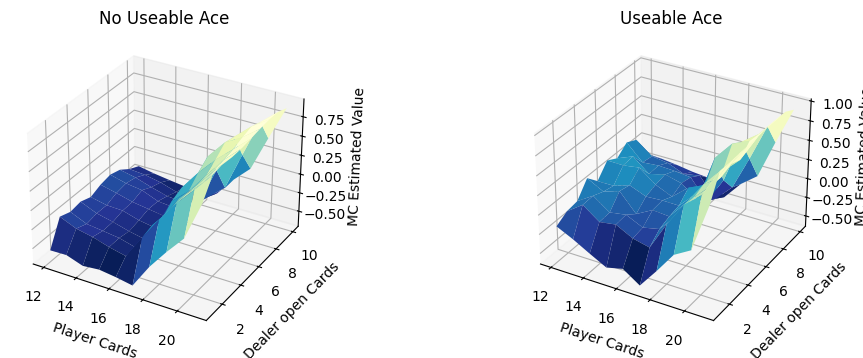

In [364]:
#시각화
X, Y = np.meshgrid(
    np.arange(12, 22),   # player가 가진 카드 합계 (12~21)
    np.arange(1, 11))    # dealer가 공개한 카드 (1~10)

#V[(player의 hand 합계, dealer 공개 카드, 사용 가능한 에이스 보유)]
no_usable_ace = np.apply_along_axis(lambda idx: V[(idx[0], idx[1], False)],
                                    2, np.dstack([X, Y]))
usable_ace = np.apply_along_axis(lambda idx: V[(idx[0], idx[1], True)],
                                 2, np.dstack([X, Y]))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4),
                               subplot_kw={'projection': '3d'})

ax0.plot_surface(X, Y, no_usable_ace, cmap=plt.cm.YlGnBu_r)
ax0.set_xlabel('Player Cards')
ax0.set_ylabel('Dealer open Cards')
ax0.set_zlabel('MC Estimated Value')
ax0.set_title('No Useable Ace')

ax1.plot_surface(X, Y, usable_ace, cmap=plt.cm.YlGnBu_r)
ax1.set_xlabel('Player Cards')
ax1.set_ylabel('Dealer open Cards')
ax1.set_zlabel('MC Estimated Value')
ax1.set_title('Useable Ace')

plt.show()

In [6]:
## Monte Carlo

win_cnt = 0
lose_cnt = 0
draw_cnt = 0
GAMMA = 1

e = 0.2
num_episodes = 1_000_000

env = gym.make("Blackjack-v1", sab=True)
num_actions = env.action_space.n

In [7]:
pi = defaultdict(lambda: np.ones(num_actions, dtype=float)/num_actions)
Q = defaultdict(lambda: np.zeros(num_actions))
Returns = defaultdict(list)

print(pi)
print(Q)
print(Returns)

defaultdict(<function <lambda> at 0x0000014FBA1DB640>, {})
defaultdict(<function <lambda> at 0x0000014FDA6AFEB0>, {})
defaultdict(<class 'list'>, {})


In [8]:
for i in range(num_episodes):
    episode = []
    s, _ = env.reset()

    while True:
        P = pi[s]
        a = np.random.choice(np.arange(len(P)), p = P)
        s_, r, terminated, truncated, _ = env.step(a)
        episode.append((s, a, r))

        if terminated or truncated:
            if r == 1:
                win_cnt += 1
            elif r == -1:
                lose_cnt += 1
            else:
                draw_cnt += 1
            break
        s = s_

    G = 0
    visited_state_action_pair = []

    for s, a, r in episode[::-1]:
        G = GAMMA*G + r

        if (s, a) not in visited_state_action_pair:
            Returns[(s, a)].append(G)
            Q[s][a] = np.mean(Returns[(s, a)])
            visited_state_action_pair.append((s, a))
        
        A_star = np.argmax(Q[s])

        for a in range(num_actions):
            if a == A_star:
                pi[s][a] = 1 - e + e/num_actions
            else:
                pi[s][a] = e/num_actions
    
    if i % 100000 == 0:
        print(f"{i}/{num_episodes} episode completed")

0/1000000 episode completed
100000/1000000 episode completed
200000/1000000 episode completed
300000/1000000 episode completed
400000/1000000 episode completed
500000/1000000 episode completed
600000/1000000 episode completed
700000/1000000 episode completed
800000/1000000 episode completed
900000/1000000 episode completed


In [9]:
print("win = {:.2f}%".format(100*win_cnt/num_episodes))
print("lose = {:.2f}%".format(100*lose_cnt/num_episodes))
print("draw = {:.2f}%".format(100*draw_cnt/num_episodes))

win = 40.27%
lose = 52.24%
draw = 7.49%


In [11]:
Q

defaultdict(<function __main__.<lambda>()>,
            {(19, 9, 0): array([ 0.28350515, -0.72260749]),
             (20, 6, 0): array([ 0.71138008, -0.85085837]),
             (18, 6, 0): array([ 0.28102258, -0.6884984 ]),
             (20, 6, 1): array([0.70364964, 0.16564417]),
             (16, 6, 1): array([-0.19230769,  0.11510129]),
             (14, 8, 0): array([-0.52299465, -0.40896044]),
             (18, 7, 0): array([ 0.40594181, -0.65825688]),
             (10, 10, 0): array([-0.57937585, -0.11181278]),
             (16, 10, 1): array([-0.54      , -0.30426673]),
             (16, 5, 0): array([-0.16850101, -0.53082707]),
             (14, 5, 0): array([-0.163965  , -0.38666667]),
             (21, 2, 1): array([0.98403141, 0.16703297]),
             (14, 9, 0): array([-0.52925068, -0.53919694]),
             (12, 9, 0): array([-0.51787774, -0.3977053 ]),
             (17, 10, 0): array([-0.45970326, -0.65642616]),
             (13, 1, 0): array([-0.77257525, -0.58753598]

In [12]:
V = defaultdict(float)

for state, actions in  Q.items():
    action_value = np.max(actions)
    V[state] = action_value

In [13]:
V

defaultdict(float,
            {(19, 9, 0): np.float64(0.28350515463917525),
             (20, 6, 0): np.float64(0.7113800848515098),
             (18, 6, 0): np.float64(0.2810225788393357),
             (20, 6, 1): np.float64(0.7036496350364964),
             (16, 6, 1): np.float64(0.1151012891344383),
             (14, 8, 0): np.float64(-0.40896043928616),
             (18, 7, 0): np.float64(0.40594181459566075),
             (10, 10, 0): np.float64(-0.11181277860326895),
             (16, 10, 1): np.float64(-0.30426672884122175),
             (16, 5, 0): np.float64(-0.1685010075957216),
             (14, 5, 0): np.float64(-0.16396499784822838),
             (21, 2, 1): np.float64(0.9840314136125654),
             (14, 9, 0): np.float64(-0.5292506845904904),
             (12, 9, 0): np.float64(-0.3977052984401186),
             (17, 10, 0): np.float64(-0.4597032567109397),
             (13, 1, 0): np.float64(-0.5875359779752222),
             (13, 1, 1): np.float64(-0.355128205128205

In [25]:
sample_state = (17, 10, True)

optimal_action = np.argmax(Q[sample_state])

state_value = V[sample_state]

print('optimal action =', optimal_action)
print('State value =', state_value)

optimal action = 1
State value = -0.2854192482445271


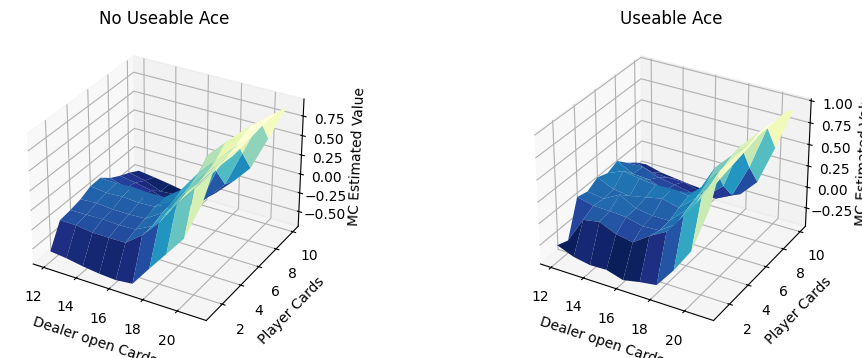

In [26]:
#시각화
X, Y = np.meshgrid(
    np.arange(12, 22),   # player가 가진 카드 합계 (12~21)
    np.arange(1, 11))    # dealer가 공개한 카드 (1~10)

#V[(player의 hand 합계, dealer 공개 카드, 사용 가능한 에이스 보유)]
no_usable_ace = np.apply_along_axis(lambda idx: V[(idx[0], idx[1], False)],
                                    2, np.dstack([X, Y]))
usable_ace = np.apply_along_axis(lambda idx: V[(idx[0], idx[1], True)],
                                 2, np.dstack([X, Y]))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4),
                               subplot_kw={'projection': '3d'})

ax0.plot_surface(X, Y, no_usable_ace, cmap=plt.cm.YlGnBu_r)
ax0.set_xlabel('Dealer open Cards')
ax0.set_ylabel('Player Cards')
ax0.set_zlabel('MC Estimated Value')
ax0.set_title('No Useable Ace')

ax1.plot_surface(X, Y, usable_ace, cmap=plt.cm.YlGnBu_r)
ax1.set_xlabel('Dealer open Cards')
ax1.set_ylabel('Player Cards')
ax1.set_zlabel('MC Estimated Value')
ax1.set_title('Useable Ace')

plt.show()